<a href="https://colab.research.google.com/github/Mikhail-Klochkov/ml_intro/blob/master/Klochkov_Task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [1]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv
from tqdm import tqdm

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()


img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

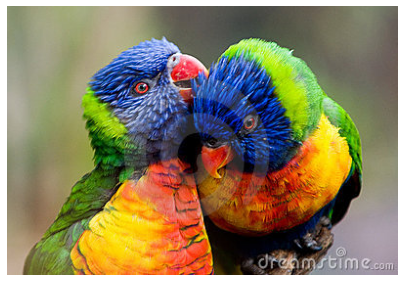

In [2]:
img = cv2.imread('bird.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [3]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [4]:
import numpy as np

class TransformsImage():
  def __init__(self, img):
    self._koef = 255.
    self._H = img.shape[0]
    self._W = img.shape[1]
    self._ch = img.shape[2]

  def uni2255(self, img):
    """
    Take image and pixels [0, 1] range and return [0, 255]
    """
    img = np.clip(img, 0., 1.)
    return np.array(img * 255, dtype = np.uint8)

  def _2552uni(self, img):
    """
    Take image in [0,255] to range [0, 1]
    """
    img = np.clip(img, 0, 255)
    return np.array(img/255., np.float32)

  def resizerepr2seq(self, img):
    """
    flatten original image [W, H, ch] in [W*H, ch]
    """
    assert(img.shape.__len__() == 3)
    _, _, num_ch = img.shape
    return img.reshape((-1, num_ch))
  
  def resizerepr2img(self, img):
    """
    takes img - [H*W, ch] 
    return - [W, H, ch]
    """
    return img.reshape((self._H, self._W, self._ch))

  def bgr2rgb(self, img):
    """
    taked img - [W, H, 3] (BGR - representation)
    returne [W, H, 3] (RGB representation)
    """
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    return img  

transformer = TransformsImage(img)

K-means


### Кластеризация в исходном пространстве пикселей 3.

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from skimage.metrics import structural_similarity as ssim

Тут самому хочеться аккуратно сделать!

In [6]:
def segmentation(img, labels, transformer_img):
  """
  we take img - [H*W, ch]
  return segmentated image of [H, W, ch]
  """
  assert(img.shape.__len__() == 2)
  for idx, l in enumerate(np.unique(labels)):
    #print('unique: {}'.format(l))
    img[labels == l, :] = img[labels == l, :].mean(axis = 0)

  return transformer_img.resizerepr2img(img)


def L2_loss(X1, X2):
  return np.sqrt(np.sum(np.square((X1 - X2))))

def L1_loss(X1, X2):
  return np.sqrt(np.sum(np.fabs((X1 - X2))))



In [7]:
k = np.array([2, 3, 10, 20])

Просто отрисуем пример кластеризации Kmeans с 6 кластерами.

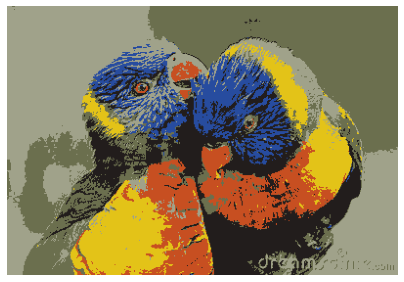

In [8]:
# для произвольного
transformer = TransformsImage(img)
img_01 = transformer._2552uni(img)
img_01_reshape = transformer.resizerepr2seq(img_01)

kmeans_sklearn = KMeans(n_clusters = 6)
kmeans_sklearn.fit(img_01_reshape)
draw_picture(segmentation(img_01_reshape, kmeans_sklearn.labels_, transformer))


100%|██████████| 4/4 [00:17<00:00,  4.41s/it]


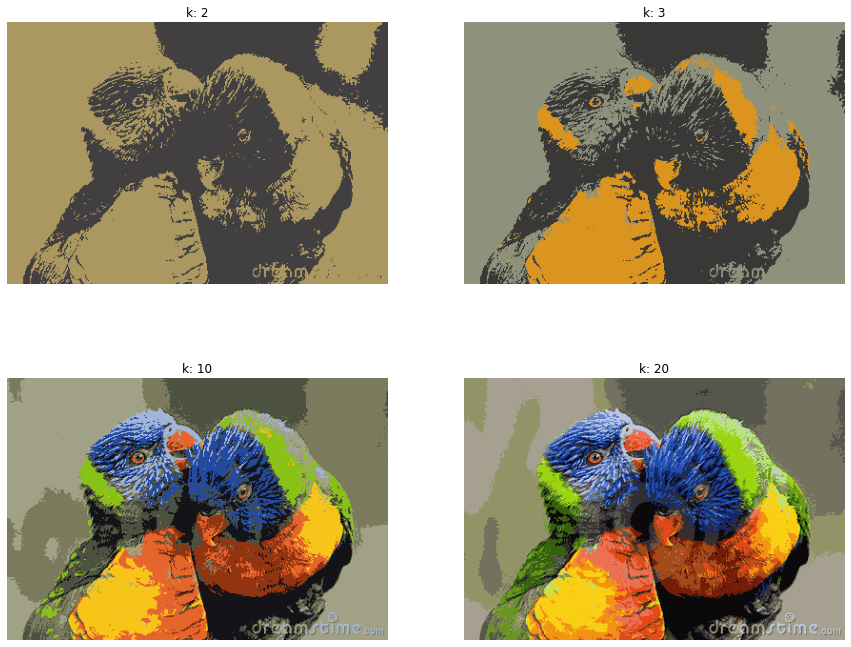

In [9]:

fig, ax = plt.subplots(2, 2, figsize = (15, 12))
ax = ax.flatten()
l1_loss = []
l2_loss = []
ssim_arr_kmeans = []

for idx in tqdm(range(ax.shape[0])):

  # -- made our data for segmenttion useful -- #
  transformer = TransformsImage(img)
  img_01 = transformer._2552uni(img)
  img_01_reshape = transformer.resizerepr2seq(img_01)
  
  km = KMeans(n_clusters = k[idx])
  km.fit(img_01_reshape)
  image_seg_bgr = segmentation(img_01_reshape, km.labels_, transformer)
  image_seg_rgb = transformer.bgr2rgb(image_seg_bgr)

  # -- calculate losses -- #
  l1_loss.append(L1_loss(image_seg_rgb, img))
  l2_loss.append(L2_loss(image_seg_rgb, img))
  ssim_arr_kmeans.append(ssim(img, image_seg_rgb, 
                       data_range = image_seg_rgb.max()-image_seg_rgb.min(),
                       multichannel = True))

  ax[idx].imshow(image_seg_rgb)
  ax[idx].axis('off')
  ax[idx].set_title('k: {}'.format(k[idx]))

plt.show()
#draw_picture(segmentation(img_01_reshape, labels_, transformer))


In [10]:
ssim_arr_kmeans

[4.8690689128002915e-05,
 5.188165918686491e-05,
 6.504211932011929e-05,
 7.470773313288157e-05]

In [11]:
from tqdm import tqdm
from scipy.spatial.distance import cdist

Вообще говоря поиск наилучшего k для алгоритма kmeans получается с помощью анализа суммы внутрикластерных расстояний между объектами. Так как данная сумма есть функционал, которые минимизируется алгоритмом kmeans. Поэтому логично для поиска k_opt найти тот, k начиная с которого сумма внутрикластерных расстояний начинате слабо падать. 

Понятно, что данное расстояние уйдёт в ноль, когда число кластеров будет ровняться число объектов в выборке, поэому мы ищем некоторый k начиная с которого J  будет падать "менее быстро". 

9it [00:18,  2.07s/it]


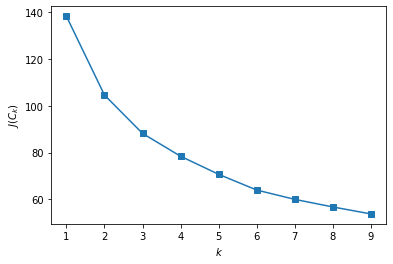

In [12]:
# Поиск оптимального k у Kmeans 


def J(X, means, labels):
  """
  X - array [N, d]
  means - array [k, d]
  labels - array [N, ] consists unique labels to indicate cluster 
  """
  assert(means.shape[0] == np.unique(labels).shape[0])
  assert(X.shape[0] == labels.shape[0])
  distances = np.square(cdist(X, means)) 
  J = 0
  for idx, cls in enumerate(np.unique(labels)):
    J += distances[labels == cls, idx].sum()
  return np.sqrt(J)

k_wide = np.arange(1, 10, 1)
J_ = []
J_my = []
for idx, k in tqdm(enumerate(k_wide)):
  if(idx % 1 == 0):
    kmean_current = KMeans(k)
    transformer = TransformsImage(img)
    img_01 = transformer._2552uni(img)
    img_01_reshape = transformer.resizerepr2seq(img_01)
    
    kmean_current.fit(img_01_reshape)
    
    means = kmean_current.cluster_centers_
    labels = kmean_current.labels_
    J_my.append(J(img_01_reshape, means, labels))
    J_.append(kmean_current.inertia_)


plt.plot(k_wide, J_my, marker = 's');
plt.xlabel('$k$')
plt.ylabel('$J(C_{k})$');




Как видно выбор k никак в данной задаче не мотивирован. По идее данную метрику часто используют для выбора оптимального параметра для задачи кластеризации в Kmeans. Это то k, где начиная с которого наклон(убывание графика функции $J(C_{k})$) происходит "не так быстро". 

DBSCAN 


Для DBSCAN большая сложность подобрать оптимальные параметры eps, m. Обычно это можно сделать зафиксировав m и варьируя eps. Смотреть на отсортированные средние расстояния "внутри-соседские" (kneighbors = m). Построив такой график, мы ищем область, где график Mean distance over m nearest neighbours(eps) становться "круче".

all objects : (110000, 3)
we will take only 7000


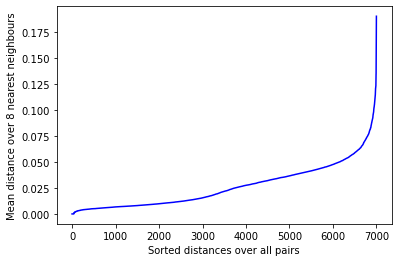

In [13]:
# Подбор оптимального eps для DBSCAN
m = 8
samples = 7000

transformer = TransformsImage(img)
img_01 = transformer._2552uni(img)
img_01_reshape = transformer.resizerepr2seq(img_01)

X_train = img_01_reshape
print('all objects : {}'.format(X_train.shape))
print('we will take only {}'.format(samples))
index = np.random.choice(range(X_train.shape[0]), size = samples)
X_samples = X_train[index, :]

# --dists-- #
dists = cdist(X_samples, X_samples)
indexes = dists.argsort(axis = 1)

indexes = indexes[:,1: m + 1]
means_distance = [dists[idx, indexes[idx, :]].mean() for idx in range(dists.shape[0])]
means_distance.sort()

# -- build graph -- #

plt.plot(range(means_distance.__len__()), means_distance, c = 'b', label = 'mean_distance_knn')
plt.xlabel('Sorted distances over all pairs')
plt.ylabel('Mean distance over {} nearest neighbours'.format(m))
plt.show();


У меня лично DBSCAN, Aglomerative падает на исходной картинке, поэтому решено было перед использованием данных алгоритмов делать pooling. 

Пример pooling в 2 раза


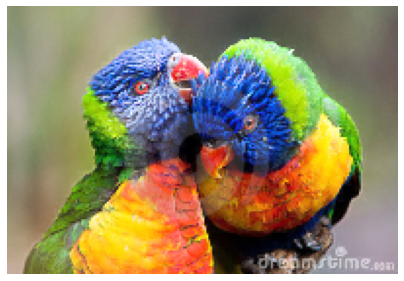

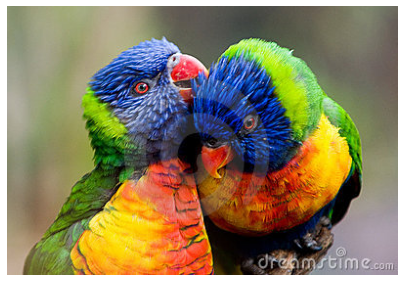

In [14]:
from itertools import product

def pooling(img, ksize, method = 'max', pad = False, info = False):
  """
  img - array it's [H, W, ch]
  ksize - (kx, ky) - tuple size of window
  method - ('max', 'mean')
  pad - ('True'/'False')
  return img [H//2, W//2, ch]
  """
  # -- if H and W don't mod 2 -- #

  m,n, _ = img.shape
  kx, ky = ksize
  _ceil_f = lambda x, y: int(np.ceil(x/float(y)))

  if pad:
    ny = _ceil_f(m, ky)
    nx = _ceil_f(n, kx)

    size = (ny * ky, nx* kx) + img.shape[2:]
    img_pad = np.full(size, np.nan)
    img_pad[:m, :n, ...] = img

  else:
    ny = m//ky
    nx = n//kx
    img_pad = img[:ny*ky, : nx*kx, ...]

  new_shape = (ny,nx) + img.shape[2:]
  img_resize = np.empty(new_shape)

  if(info):
    print('pad: {} old image size: {}\nand new size of image: {}\nafter resize: {}'.format(pad, 
                                                                                          img.shape, 
                                                                                          img_pad.shape,
                                                                                          img_resize.shape))
  
  zip_index = zip(product(range(0, img_pad.shape[0], ky), 
                      range(0, img_pad.shape[1], kx)), product(range(0, ny, 1), 
                                                               range(0, nx, 1)))
  
  for idn, (idx_pad, idx_new) in enumerate(zip_index, start = 0):
    if method == 'max':
      img_resize[idx_new[0], idx_new[1]] = img_pad[idx_pad[0]: idx_pad[0] + ky, 
                                                   idx_pad[1]: idx_pad[1] + kx].max(axis = (0, 1))
    else:
      img_resize[idx_new[0], idx_new[1]] = img_pad[idx_pad[0]: idx_pad[0] + ky,
                                                   idx_pad[1]: idx_pad[0] + kx].mean(axis = (0, 1))


  return img_resize

  
img_pool = pooling(img, ksize = (2, 2), pad = False, method = 'max')
t_resize = TransformsImage(img_pool)
img_pool = t_resize._2552uni(img_pool)

print('Пример pooling в 2 раза')
draw_picture(img_pool)
draw_picture(img)


DBSCAN - важно настроить для фиксированного m окрестность eps так как мы вообще ничего не знам про то, какие характерные плотности имееют объекты данных! Очень важно. А может быть разобраться в EM? Kmean - это тривиальнейшее обобщение EM.

У меня DBSCAN падает ОЗУ, если я использую все пиксели картинки. То есть сложность по памяти у dbscan ~ O(k*n) это порядка ~ 1 мл. Что не позволяет нормально подсчитать. Для этого я в начале преобразую картинку max pooling чтобы уменьшить размерность задачи, после делаю кластеризацию и далее делаю resize kneareast interpolation. И далее уже сравниваю наши значения.

9it [00:06,  1.49it/s]


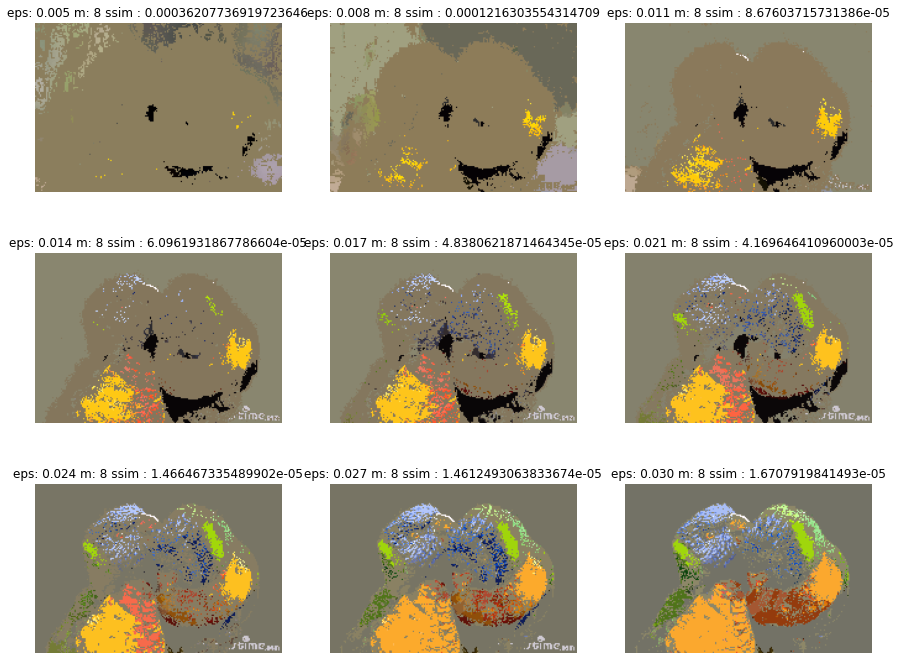

In [15]:
# -- такие результаты получились на m = 8 и на eps (ниже смотреть) -- #
eps = 0.02
epss = np.linspace(0.005, 0.03, 9)
m = 8

fig, ax = plt.subplots(3, 3, figsize = (15, 12))
ax = ax.flatten()

l1_loss_dbscan = []
l2_loss_dbscan = []
ssim_arr_dbscan = []
times = 0

for idx, eps in tqdm(enumerate(epss, start = 1)):

  # -- made our data for segmenttion useful -- #
  img = cv2.imread('bird.jpg') # считать картинку
  init_m, init_n, _ = img.shape
  # -- decrease image in 2 times -- #
  # -- max pooling -- #
  img_new = pooling(img, ksize = (2, 2), method= 'max', pad = False)
  transformer = TransformsImage(img_new)
  img_01_new = transformer._2552uni(img_new)
  img_01_new_reshape = transformer.resizerepr2seq(img_01_new)

  # -- fit dbscan -- #
  db = DBSCAN(eps = eps, min_samples = m, algorithm = 'kd_tree')
  db.fit(img_01_new_reshape)
  # -- end fit -- #

  # -- create segmentation image -- #

  image_seg_bgr = segmentation(img_01_new_reshape, db.labels_, transformer)
  image_seg_rgb = transformer.bgr2rgb(image_seg_bgr)

  # --return original size of images -- #
  image_seg_rgb = cv2.resize(image_seg_rgb, 
                             (init_n, init_m), 
                             interpolation = cv2.INTER_NEAREST)

  # -- calculate losses -- #
  l1_loss_dbscan.append(L1_loss(image_seg_rgb, img))
  l2_loss_dbscan.append(L2_loss(image_seg_rgb, img))
  ssim_arr_dbscan.append(ssim(img, image_seg_rgb,
                              multichannel = True, 
                              data_range = image_seg_rgb.max() - image_seg_rgb.min(),
                              ))


  # -- build graphs -- #
  if times < ax.shape[0]:
    ax[times].imshow(image_seg_rgb)
    ax[times].axis('off')
    ax[times].set_title('eps: {:.3f} m: {} ssim : {}'.format(eps, 
                                                             m,
                                                             ssim_arr_dbscan[-1]))
    times += 1
plt.show()
#draw_picture(segmentation(img_01_reshape, labels_, transformer))


In [18]:
ssim_arr_dbscan

[0.00036207736919723646,
 0.0001216303554314709,
 8.67603715731386e-05,
 6.0961931867786604e-05,
 4.8380621871464345e-05,
 4.169646410960003e-05,
 1.466467335489902e-05,
 1.4612493063833674e-05,
 1.6707919841493e-05]

Aglomerateive

Aglomerative clusterization. Этот метод имеет различные сопособы соединения последовательно кластеры в один, для этого используются различные определения расстояния между кластерами. Желательно выбирать расстояние Уорена либо максимальное pair расстояние между элментами кластеров. Данные определения расстояний имеет хорошие свойства. Например расстояния между последовательными двумя слияниями кластеров в алгоритме aglomerative clusterization должны обладать свойством монотонности. 


0it [00:00, ?it/s]
1it [00:28, 28.07s/it]
2it [00:55, 27.75s/it]
3it [01:22, 27.51s/it]
4it [01:49, 27.37s/it]


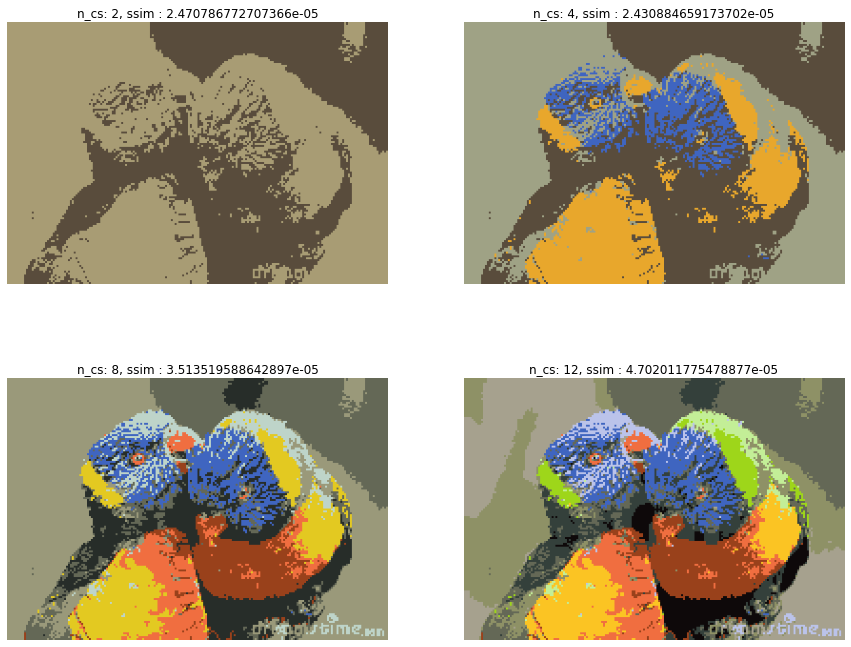

In [20]:
n_clusters = np.array([2, 4, 8, 12])

fig, ax = plt.subplots(2, 2, figsize = (15, 12))
ax = ax.flatten()

l1_loss_dbscan = []
l2_loss_dbscan = []
ssim_arr_aglomerative = []
times = 0

for idx, c in tqdm(enumerate(n_clusters, start = 1)):

  # -- made our data for segmenttion useful -- #
  img = cv2.imread('bird.jpg') # считать картинку
  init_m, init_n, _ = img.shape
  # -- decrease image in 2 times -- #
  # -- max pooling -- #
  img_new = pooling(img, ksize = (2, 2), method= 'max', pad = False)
  transformer = TransformsImage(img_new)
  img_01_new = transformer._2552uni(img_new)
  img_01_new_reshape = transformer.resizerepr2seq(img_01_new)

  # -- fit aglomerative -- #
  agg = AgglomerativeClustering(n_clusters = c)
  agg.fit(img_01_new_reshape)
  # -- end fit -- #

  # -- create segmentation image -- #

  image_seg_bgr = segmentation(img_01_new_reshape, agg.labels_, transformer)
  image_seg_rgb = transformer.bgr2rgb(image_seg_bgr)

  # --return original size of images -- #
  image_seg_rgb = cv2.resize(image_seg_rgb, 
                             (init_n, init_m), 
                             interpolation = cv2.INTER_NEAREST)

  # -- calculate losses -- #
  l1_loss_dbscan.append(L1_loss(image_seg_rgb, img))
  l2_loss_dbscan.append(L2_loss(image_seg_rgb, img))
  ssim_arr_aglomerative.append(ssim(img, image_seg_rgb,
                              multichannel = True, 
                              data_range = image_seg_rgb.max() - image_seg_rgb.min(),
                              ))


  # -- build graphs -- #
  if times < ax.shape[0]:
    ax[times].imshow(image_seg_rgb)
    ax[times].axis('off')
    ax[times].set_title('n_cs: {}, ssim : {}'.format(c,
                                                     ssim_arr_aglomerative[-1]))
    times += 1
plt.show()

In [21]:
ssim_arr_aglomerative

[2.470786772707366e-05,
 2.430884659173702e-05,
 3.513519588642897e-05,
 4.702011775478877e-05]

В сравнении с Kmeans, Aglomerative. Эти значения вообще говоря мало что могут сказать. Очень маленькие значения мы наблюдаем почти на всех алгоритмах. Значение 1 говорит об абсолютном совпадении картинок, -1 об абсолютном различие объектов, значения около 0 говорит о частичной схожести. Честно на основе исключительно значений метрики SSIM мало что можно сказать, в данном случае. 

А опираясь на зрительный анализ могу сазать, что Kmeans сработал лучшим образом, не зря на базе него есть ряд продвинутых алгоритмов kmeans-shift. 

И понятно, что при увеличении k мы полчим более детализованную картинку. 

In [25]:
print('ssim kmeans: {}'.format(ssim_arr_kmeans))
print()
print('sism aglomerative: {}'.format(ssim_arr_aglomerative))
print()
print('sism dbscan: {}'.format(ssim_arr_dbscan))
print()



ssim kmeans: [4.8690689128002915e-05, 5.188165918686491e-05, 6.504211932011929e-05, 7.470773313288157e-05]

sism aglomerative: [2.470786772707366e-05, 2.430884659173702e-05, 3.513519588642897e-05, 4.702011775478877e-05]

sism dbscan: [0.00036207736919723646, 0.0001216303554314709, 8.67603715731386e-05, 6.0961931867786604e-05, 4.8380621871464345e-05, 4.169646410960003e-05, 1.466467335489902e-05, 1.4612493063833674e-05, 1.6707919841493e-05]



# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

Как известно T-sne метод, который нужен исключительно для красивой визуализации данных на 2d-3d пространствах. Суть метода заключается в том, чтобы на основе данных о расстоянии элементов в исходном признаковом пространстве, построить 2d-3d, так чтобы близкие элементы близкие (далёкие) в исходном были близки (далеки) в 2d, 3d. Сами по себе координаты не несут информации для использования их в задачах классификации. При этом, если запускать алгоритм несколько раз, мы будем получать разные картинки.

PCA - имеет множество интерпретаций в данном случае он детерменирован +-, отличия могут быть связаны исключительно с накапливающейся вычислительной ошибкой. Он ищёт линейное подпостранство, которое лучше всего аппроксимирует выборку данных. То есть в общем решается некая задача оптимизации данных. Как следствие мы ищем такое преобразования координат, чтобы матрица ковариации данных с учётом такого преобразования была диагональной, а это значит, что координаты будут спроецированы на такие направления вдоль которых дисперсия данных максимальна. С этой точки зрения мы как-бы отсекаем часть информации в данных, оставляя только самые информативные компоненты преобразованных данных. Данную задачу можно решить используя SVD.  

Без уменьшения размерности не получилось дождаться!!!

In [27]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [28]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

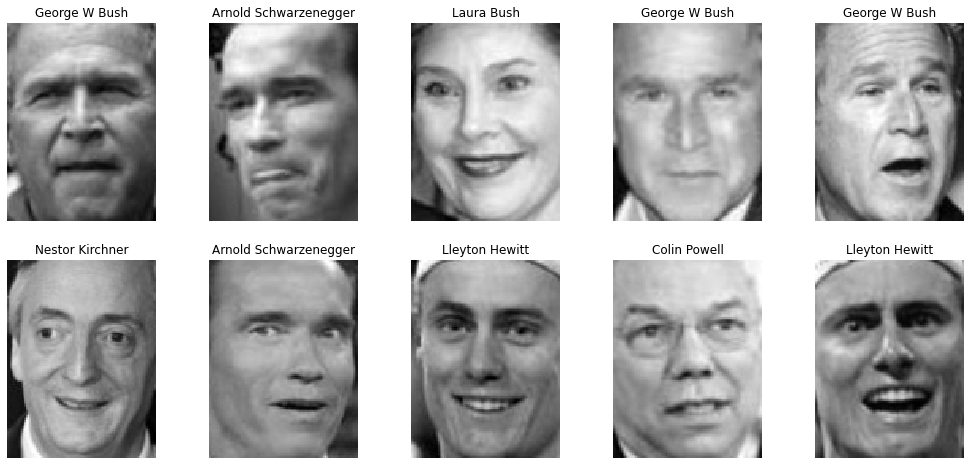

In [30]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

In [31]:
def show_image(img):
  """
  img - array [H, W] grayscale
  """
  img_copy = np.copy(img)
  img_copy = np.clip(img_copy, 0, 255)
  img_copy = np.array(img_copy, dtype = np.uint8)
  plt.imshow(img_copy, cmap = plt.cm.gray)


In [37]:
# -- Доли уникальных объектов -- #
np.unique(lfw_people.target, return_counts = True)[1]/lfw_people.images.shape[0]

array([0.0164557 , 0.01476793, 0.01518987, 0.03248945, 0.01772152,
       0.09957806, 0.01308017, 0.05105485, 0.22362869, 0.04599156,
       0.0185654 , 0.01265823, 0.0164557 , 0.02995781, 0.02194093,
       0.02320675, 0.01772152, 0.02236287, 0.01308017, 0.02531646,
       0.01350211, 0.01729958, 0.01729958, 0.02025316, 0.01392405,
       0.01561181, 0.01265823, 0.01350211, 0.02194093, 0.01392405,
       0.01392405, 0.06075949, 0.01350211, 0.02067511])

In [33]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

new_dim = np.array([10,20,50, 75, 100, 200, 500, 750, 1000])
acc = []

for idx, m in tqdm(enumerate(new_dim)):
  # --  for different components -- #
  # -- m should be <= min(num_samples, num_features)
  pca = PCA(n_components = m)
  X_train_pca = pca.fit_transform(X_train)  
  X_test_pca = pca.transform(X_test)

  pipe = Pipeline([
                  ('std', StandardScaler()),
                  ('logress', LogisticRegression(class_weight = 'balanced'))
                  ])
  
  pipe.fit(X_train_pca, y_train)
  acc.append(accuracy_score(y_test, pipe.predict(X_test_pca)))






0it [00:00, ?it/s]
1it [00:01,  1.76s/it]
2it [00:03,  1.89s/it]
3it [00:06,  2.19s/it]
4it [00:09,  2.47s/it]
5it [00:13,  2.84s/it]
6it [00:17,  3.04s/it]
7it [00:24,  4.36s/it]
8it [00:35,  6.36s/it]
9it [00:50,  5.60s/it]


График зависимости точности алгоритма в зависимости от уменьшенной размерности задачи. Для logisticregression.

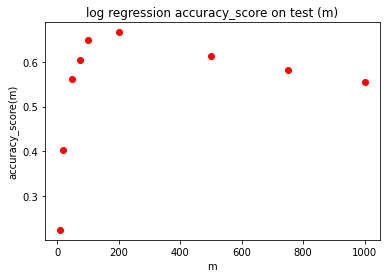

In [34]:
plt.scatter(new_dim, acc, c = 'r')
plt.title('log regression accuracy_score on test (m)')
plt.xlabel('m')
plt.ylabel('accuracy_score(m)');


In [35]:
acc_svm = []

for idx, m in tqdm(enumerate(new_dim)):
  # --  for different components -- #
  # -- m should be <= min(num_samples, num_features)
  pca = PCA(n_components = m)
  X_train_pca = pca.fit_transform(X_train)  
  X_test_pca = pca.transform(X_test)

  pipe = Pipeline([
                  ('std', StandardScaler()),
                  ('svm', SVC(class_weight = 'balanced'))
                  ])
  
  pipe.fit(X_train_pca, y_train)
  acc_svm.append(accuracy_score(y_test, pipe.predict(X_test_pca)))



0it [00:00, ?it/s]
1it [00:01,  1.80s/it]
2it [00:04,  1.96s/it]
3it [00:07,  2.35s/it]
4it [00:11,  2.85s/it]
5it [00:16,  3.47s/it]
6it [00:22,  4.41s/it]
7it [00:38,  7.77s/it]
8it [01:01, 12.46s/it]
9it [01:33, 10.39s/it]


График зависимости точности алгоритма в зависимости от уменьшенной размерности задачи. Для svm classifier.

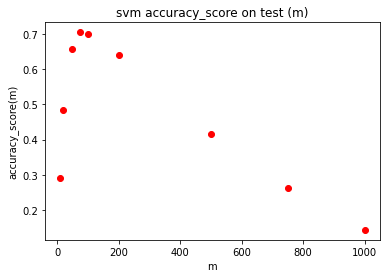

In [36]:
plt.scatter(new_dim, acc_svm, c = 'r')
plt.title('svm accuracy_score on test (m)')
plt.xlabel('m')
plt.ylabel('accuracy_score(m)');

In [40]:
the_best_dim_log = new_dim[np.argmax(acc)]
the_best_dim_svm = new_dim[np.argmax(acc_svm)]


In [62]:
the_best_dim_log, the_best_dim_svm

(200, 75)

Лучшие ответы на LogReg, SVM.

Проверим константное решение. 

In [66]:
unique, counts = np.unique(y, return_counts = True)
big_class = unique[np.argmax(counts/y.shape[0])]
print('most popular name: ', lfw_people.target_names[big_class])
print('most target: {}'.format(big_class))

most popular name:  George W Bush
most target: 8


In [67]:
y_pred_conts = np.ones((y_test.shape[0], )) * big_class

0.23839662447257384

Вывод: Наши предсказания logreg, svm намного лучше чем константное предсказание.

In [69]:
print('reduction to {} accuracy logreg: {:.3f}'.format(the_best_dim_log, np.max(acc)))
print('reduction to {} accuracy svm: {:.3f}'.format(the_best_dim_svm, np.max(acc_svm)))
print('const prediction most popular class: {:.3f}'.format(accuracy_score(y_test, y_pred_conts)))

reduction to 200 accuracy logreg: 0.667
reduction to 75 accuracy svm: 0.705
const prediction most popular class: 0.238


Отрисовать на каких данных ошибся наш алгоритм.


In [77]:
# -- log -- #

pca_log = PCA(n_components = the_best_dim_log)
X_train_pca = pca_log.fit_transform(X_train)  
X_test_pca = pca_log.transform(X_test)


pipe_log = Pipeline([
                  ('std', StandardScaler()),
                  ('logress', LogisticRegression(class_weight = 'balanced'))
                  ])
  
pipe_log.fit(X_train_pca, y_train)
y_pred_log = pipe_log.predict(pca_log.transform(X))


In [78]:
# -- svm -- #
pca_svm = PCA(n_components = the_best_dim_svm)
X_train_pca = pca_svm.fit_transform(X_train)  
X_test_pca = pca_svm.transform(X_test)

pipe_svm = Pipeline([
                  ('std', StandardScaler()),
                  ('svm', SVC(class_weight = 'balanced'))
                  ])
  
pipe_svm.fit(X_train_pca, y_train)

y_pred_svm = pipe_svm.predict(pca_svm.transform(X))

Ошибки на logreg

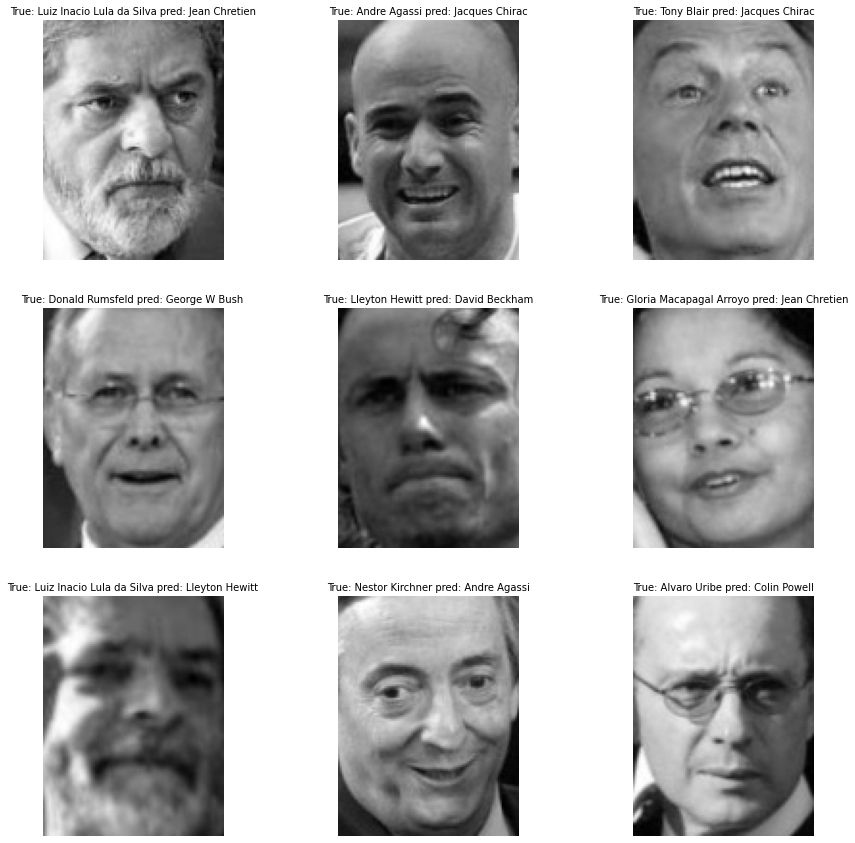

In [90]:
nums = 9
fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()

errors_log_img = lfw_people.images[y_pred_log != lfw_people.target]
errors_log_target = lfw_people.target[y_pred_log != lfw_people.target]
errors_log_preds = y_pred_log[y_pred_log != lfw_people.target]

# -- choose random 10 -- #
indexes = np.random.choice(np.arange(errors_log_img.shape[0]), size = nums)
errors_log_img = errors_log_img[indexes]
errors_log_target = errors_log_target[indexes]
errors_log_preds = errors_log_preds[indexes]


for idx in range(errors_log_img.shape[0]):
  X_img = errors_log_img[idx]
  
  ax[idx].imshow(X_img, cmap = 'gray')
  ax[idx].set_title('True: {} pred: {}'.format(lfw_people.target_names[errors_log_target[idx]],
                                               lfw_people.target_names[errors_log_preds[idx]]),
                                                fontsize= 10)
  ax[idx].axis('off')

plt.show()

Визуализация датасета на плоскости, для этого мы воспользуемся t-sne. Он отлично годиться для красивой визуализации, хоть он и долгий. Анализировать же его компоненты бессмысленно.

In [103]:
from sklearn.manifold import TSNE
# -- выберем для визуализации 10 случайных имен -- #
# -- More popular -- #

top_nums = 10
unique, counts = np.unique(lfw_people.target, return_counts=True)
top_names = unique[np.argsort(counts)[-10:]]
print('top {} names: {}'.format(top_nums, lfw_people.target_names[top_names][::-1]))

top 10 names: ['George W Bush' 'Colin Powell' 'Tony Blair' 'Donald Rumsfeld'
 'Gerhard Schroeder' 'Ariel Sharon' 'Hugo Chavez' 'Junichiro Koizumi'
 'Jean Chretien' 'John Ashcroft']


In [104]:
top_names

array([17, 15, 19, 13,  3,  9,  7, 31,  5,  8])

Если запустить дефолтно на малое число иттераций 1000.

In [127]:
# -- filter only top 10 popular people -- #
mask = [t in set(top_names.tolist()) for t in lfw_people.target]
data_top_people = lfw_people.data[mask]

# -- made first PCA -- #
X_before_pca = PCA(n_components = 200).fit_transform(data_top_people)
# -- after we made tnse на данных чуть меньшей размерности -- #
X_embedded = TSNE(n_components = 2, n_iter = 5000).fit_transform(X_before_pca)


In [128]:
data_top_target = lfw_people.target[mask]

Картинка, которая получилась с tsne, c дефолтными параметрами

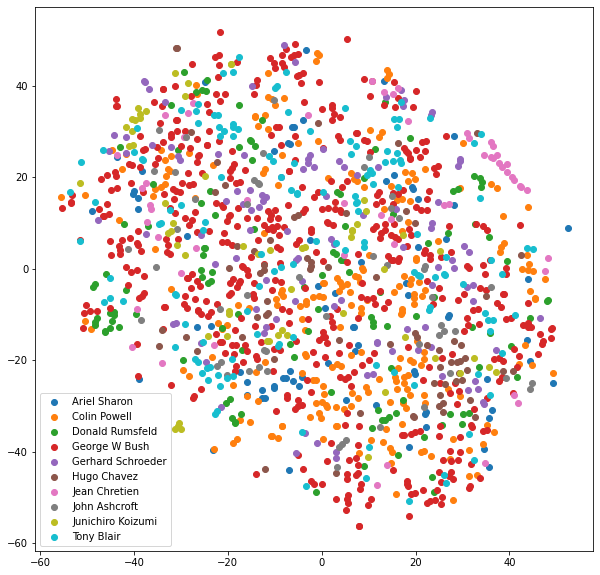

In [129]:
import matplotlib.colors as mcolors
dict_of_colors = mcolors.TABLEAU_COLORS
color_list = list(dict_of_colors.keys())

fig, ax = plt.subplots(figsize = (10, 10))

for idx, unique_t in enumerate(np.unique(data_top_target)):
  X_part = X_embedded[(data_top_target == unique_t)]
  ax.scatter(X_part[:, 0], X_part[:, 1], 
           c = color_list[idx % 10], 
           label = str(lfw_people.target_names[unique_t]))

ax.legend()

In [124]:
mask = [t in set(top_names.tolist()) for t in lfw_people.target]
data_top_people = lfw_people.data[mask]
X_embedded_pca = PCA(n_components = 2).fit_transform(data_top_people)



Посмотрим что нам даст PCA.

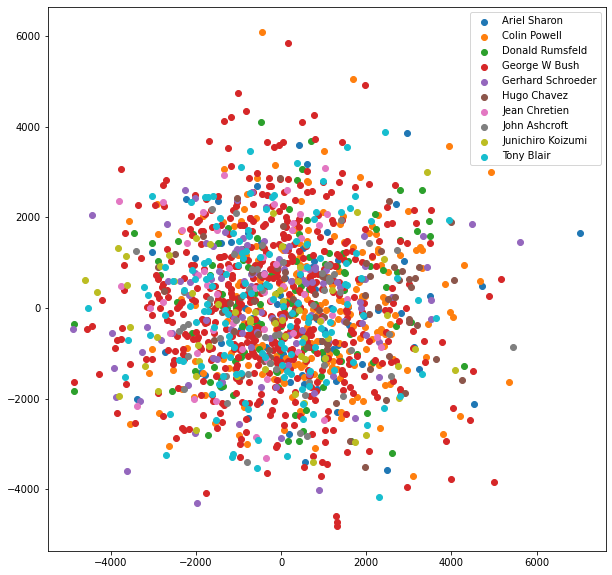

In [130]:
fig, ax = plt.subplots(figsize = (10, 10))

for idx, unique_t in enumerate(np.unique(data_top_target)):
  X_part = X_embedded_pca[(data_top_target == unique_t)]
  ax.scatter(X_part[:, 0], X_part[:, 1], 
           c = color_list[idx % 10], 
           label = str(lfw_people.target_names[unique_t]))

ax.legend()

In [118]:
# А если сделать сначала PCA а потом Tsne будет ли лучше? 
# Также вопрос, а если сделать несколько PCA с постепенным понижением размерности  будет ли отличие если разом сделать РCA  - единожды